# Spectral Subgraph Localization

**Author**: Amit Boyarski

## Intro

We are interested in solving the problem of **subgraph localization**:

Given a full graph $\mathcal{G}$ and a subgraph $\mathcal{H}$, find a subgraph (i.e., a set of nodes and edges) within $\mathcal{G}$ that matches $\mathcal{H}$ as close as possible.

The desired output is a scalar field over $\mathcal{G}$ denoting the probabilities of each node and edge belonging to $\mathcal{H}$. Note that this is a superficially simpler problem than finding full correspondence between $\mathcal{H}$ and $\mathcal{G}$.

We approach the problem by modeling it as an optimization problem over $\mathcal{G}$. Let use denote by $\mathbf{v} : \mathcal{N}\rightarrow \mathbb{R}^{\mathcal{N}}$ and $\mathbf{E}: {\mathcal{N} \times \mathcal{N}}\rightarrow \mathbb{R}^{\mathcal{N} \times \mathcal{N}}$ two scalar fields (i.e., "masks") over the nodes and edges of $\mathcal{G}$. We shall denote the Laplacian of $\mathcal{G}$ by $\mathbf{L} = \mathbf{D}-\mathbf{A}$, where $\mathbf{A}$ is the adjacency matrix $\mathbf{D}\equiv \textbf{diag}(\mathbf{A}\mathbf{1})$ is the degree matrix of $\mathcal{G}$.

The edge potential $\mathbf{E}$ is used to detach the subgraph from the full graph, i.e., by demanding $\mathbf{L}_E = \mathbf{L}+\mathbf{E}$ to be a Laplacian of a graph composed of two disconnected components (one of which corresponds to $\mathcal{H}$). Once the subgraph has been detached, we use the node potential $\mathbf{v}$ to modify the spectrum of the edited Laplacian $\mathbf{L}_E$ such that it should match the spectrum of the Laplacian of $mathcal{H}$.

To that end, we model the problem via an optimization problem with a data term and regularization terms:


$$
\min_{\mathbf{E},\mathbf{v}} \mu_{spect}\|\mathbf{\lambda}(\mathbf{L}+\mathbf{E}+\text{diag}(\mathbf{v})) - \mathbf{\lambda}_{ref}\|^2 +
 \mu_{sparse} \|\mathbf{E}\|_{2,1}+\mu_{split}\lambda_{2}(\mathbf{L}+\mathbf{E})+\mu_{MS} \mathbf{v}^T\bigl( \mathbf{L}+\mathbf{E}\bigr) \mathbf{v}
$$
$$
\text{s.t.}\;\;\mathbf{E}=\mathbf{E}^\top,\mathbf{E}\mathbf{1}=\mathbf{0},\;\text{offdiag}(\mathbf{L}+\mathbf{E})\leq 0,\;\text{tr}(\mathbf{E}) = k
$$


- The first term (spectral alignment term) is supposed to align the spectra of the localized subgraph with that of the reference subgraph $\mathcal{H}$.
- The second term is supposed to restrict the number of detached edges, e.g., by making the editing  Laplacian matrix sparse.
- The third term penalizes the second eigenvalue of the edited Laplacian, thus enforcing the edited graph to have disconnected components.
- The fourth term is in order to make sure that $\mathbf{v}$ is piecewise constant, i.e., it should equal $0$ outside our subgraph and $\infty$ (or some large number) on the subgraph. Alternatively, it pushes $\mathbf{v}$ into the nullspace of the edited Laplacian.
- The constraints ensure that $\mathbf{L}_E$ is a valid Laplacian.

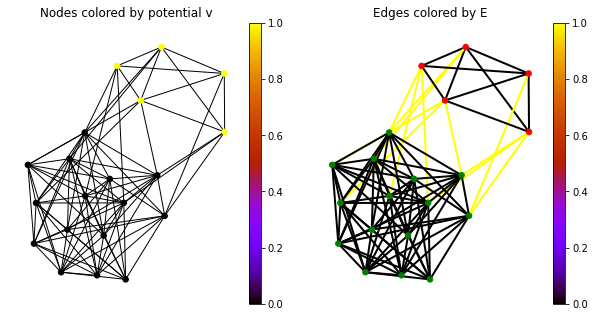

In [25]:
from optimization.prox.prox import ProxNonNeg,\
    ProxL21ForSymmCentdMatrixAndInequality, ProxL1ForSymmCentdMatrixAndInequality

from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from problem.spectral_subgraph_localization import block_stochastic_graph,\
    SubgraphIsomorphismSolver

#torch.manual_seed(12)

n1 = 5
n2 = 15
n = n1 + n2
p = block_stochastic_graph(n1, n2, p_parts=0.7, p_off=0.1)

A = torch.tril(torch.bernoulli(p)).double()
A = (A + A.T)
D = torch.diag(A.sum(dim=1))
L = D - A

# plt.imshow(A)
# plt.title('A')
# plt.show()

A_sub = A[0:n1, 0:n1]
D_sub = torch.diag(A_sub.sum(dim=1))
L_sub = D_sub - A_sub
ref_spectrum = torch.linalg.eigvalsh(L_sub)

v_gt = np.zeros(n)
v_gt[0:n1] = 1.0
E_gt = np.zeros_like(A)
E_gt[0:n1, n1:n] = A[0:n1, n1:n]
E_gt[n1:n, 0:n1] = A[n1:n, 0:n1]


SubgraphIsomorphismSolver.plot_on_graph(A=A.numpy().astype(int),
                                          n_subgraph=n1,
                                          v=v_gt,
                                          E=E_gt)


In [35]:
from optimization.prox.prox import ProxId

params = {'mu_spectral': 0.1,
          'mu_l21': 0.1,
          'mu_MS': 0.1,
          'mu_split': 0.1,
          'mu_trace': 0.0,
          'lr': 0.02,
          'v_prox': ProxId(),
          #'E_prox': ProxL21ForSymmetricCenteredMatrix(solver="cvx"),
          'E_prox': ProxL21ForSymmCentdMatrixAndInequality(solver="cvx", L=L,
                                                            trace_upper_bound=
                                                            1.1*torch.trace(L)),
          # 'E_prox': ProxL1ForSymmCentdMatrixAndInequality(solver="cvx", L=L,
          #                                                 trace_upper_bound=
          #                                                 1.1 * torch.trace(L)),
          'trace_val': 0
          }
subgraph_isomorphism_solver = SubgraphIsomorphismSolver(L, ref_spectrum, params)

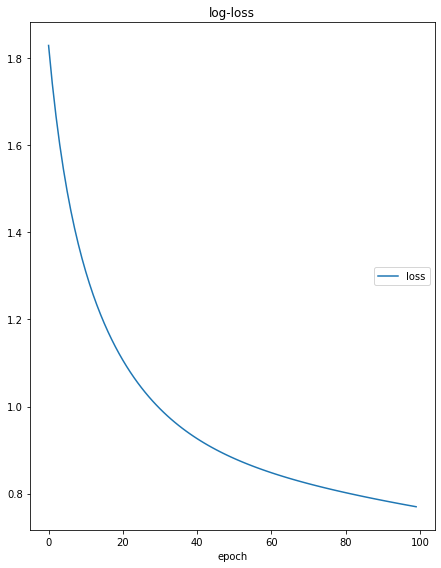

100%|██████████| 1000/1000 [01:04<00:00, 15.41it/s]

done
v= tensor([0.2046, 0.2078, 0.2337, 0.2713, 0.2303, 0.3471, 0.3383, 0.3277, 0.3463,
        0.3459, 0.3468, 0.3495, 0.3457, 0.3295, 0.3231, 0.3237, 0.3488, 0.3341,
        0.3409, 0.3417], dtype=torch.float64, requires_grad=True)
E= tensor([[-1.0434e+00,  1.2001e-01,  4.8150e-01,  9.0205e-02,  3.5173e-01,
         -1.0851e-10, -9.7327e-11, -1.0391e-10, -1.1380e-10, -1.1421e-10,
         -1.0237e-10, -1.0313e-10, -1.1668e-10, -9.4347e-11, -1.0790e-10,
         -5.8115e-10, -1.0663e-10, -6.7939e-10, -1.1201e-10, -1.1290e-10],
        [ 1.2001e-01, -7.1262e-01,  2.0055e-01,  7.8467e-02,  3.1358e-01,
         -1.1846e-10, -1.1423e-10, -1.1207e-10, -1.3106e-10, -1.2946e-10,
         -1.1946e-10, -1.3141e-10, -1.3307e-10, -1.0831e-10, -1.5365e-09,
         -1.2950e-10, -1.3246e-10, -1.2419e-10, -1.1744e-10, -1.2380e-10],
        [ 4.8150e-01,  2.0055e-01, -5.8799e-01, -7.0475e-02, -2.3581e-02,
         -1.1970e-10, -9.5196e-10, -1.3753e-10, -1.0617e-10, -1.0775e-10,
         -1.1406e-10,

In [36]:
v, E = subgraph_isomorphism_solver.solve(maxiter=1000, show_iter= 10)


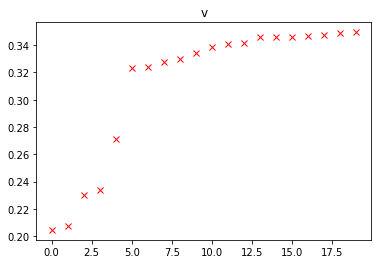

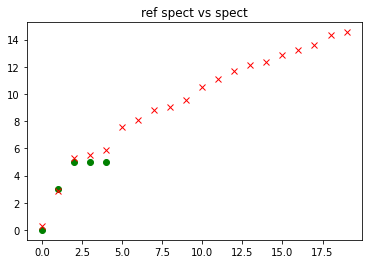

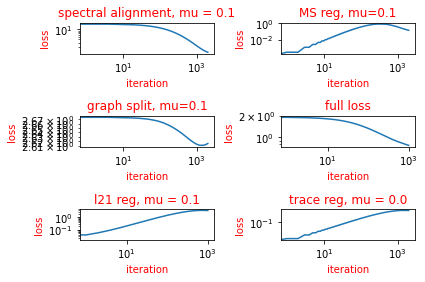

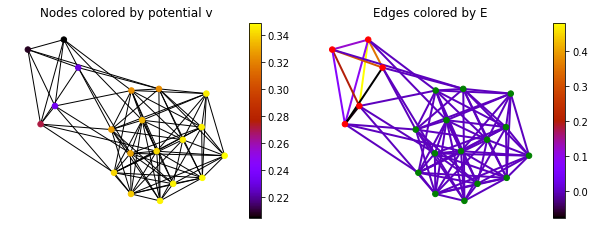

In [37]:
plots = {
    'full_loss': False,
    'E': False,
    'v': True,
    'diag(v)': False,
    'v_otsu': False,
    'v_kmeans': False,
    'A edited': False,
    'L+E': False,
    'ref spect vs spect': True,
    'individual loss terms': True}

subgraph_isomorphism_solver.plot(plots)
subgraph_isomorphism_solver.plot_on_graph(A=A.numpy().astype(int),
                                          n_subgraph=n1,
                                          v=v.detach().numpy(),
                                          E=E.detach().numpy())
